In [69]:
import csv
import sys
import os
import re
import datetime
import time
import numpy as np
import pandas as pd

In [96]:
calender_df = pd.read_csv('calender_data.csv', encoding='utf-8')

cm_data_df = pd.read_csv('cm_data.csv')

regi_acc_get_data_df = pd.read_csv('regi_acc_get_data_transform.csv')

regi_call_data_df = pd.read_csv('regi_call_data_transform.csv')

gt_service_name_df = pd.read_csv('gt_service_name.csv')
# Convert the 'week' column to datetime type
gt_service_name_df['cdr_date'] = pd.to_datetime(gt_service_name_df['week'])

# Set the 'week' column as the index
gt_service_name_df.set_index('cdr_date', inplace=True)

# Resample the dataframe to daily frequency and forward fill missing values
gt_service_df = gt_service_name_df.resample('D').ffill()

# Reset the index to make 'week' a column again
gt_service_df.reset_index(inplace=True)
gt_service_df.drop('week', axis=1, inplace=True)

calender_df['cdr_date'] = pd.to_datetime(calender_df['cdr_date'])
regi_acc_get_data_df['cdr_date'] = pd.to_datetime(regi_acc_get_data_df['cdr_date'])
cm_data_df['cdr_date'] = pd.to_datetime(cm_data_df['cdr_date'])
gt_service_df['cdr_date'] = pd.to_datetime(gt_service_df['cdr_date'])
regi_call_data_df['cdr_date'] = pd.to_datetime(regi_call_data_df['cdr_date'])

In [114]:
merged_df = pd.merge(regi_call_data_df, regi_acc_get_data_df, on='cdr_date', how='outer')
merged_df = pd.merge(merged_df, calender_df, on='cdr_date', how='outer')
merged_df = pd.merge(merged_df, cm_data_df, on='cdr_date', how='outer')
merged_df = pd.merge(merged_df, gt_service_df, on='cdr_date', how='outer')


start_date = '2018-06-01'
timestamp = pd.Timestamp(start_date)

end_date = '2020-03-31'
filtered_df = merged_df[(merged_df['cdr_date'] >= start_date) & (merged_df['cdr_date'] <= end_date)]

filtered_df['days_from_start'] = (filtered_df['cdr_date'] - timestamp).dt.days


filtered_df['day_before_holiday_flag'] = filtered_df['day_before_holiday_flag'].astype(int)
filtered_df['holiday_flag'] = filtered_df['holiday_flag'].astype(int)

filtered_df['holiday_name'] = filtered_df['holiday_name'].fillna(0).apply(lambda x: 1 if x != 0 else 0)

dow_name_mapping = {'日': 1, '月': 2, '火': 3, '水': 4, '木': 5, '金': 6, '土': 7}
filtered_df['dow_name'] = filtered_df['dow_name'].map(dow_name_mapping)



missing_search_cnt_rows = filtered_df[filtered_df['search_cnt'].isnull()].head(2)
average_search_cnt_cm_flg_1 = filtered_df[filtered_df['cm_flg'] == 1]['search_cnt'].mean()
filtered_df['search_cnt'] = filtered_df['search_cnt'].fillna(average_search_cnt_cm_flg_1)


filtered_df['previous_acc_get_cnt'] = filtered_df['acc_get_cnt'].shift(5)
filtered_df.loc[92, 'previous_acc_get_cnt'] = 0
filtered_df.loc[93, 'previous_acc_get_cnt'] = 0
filtered_df.loc[94, 'previous_acc_get_cnt'] = 0
filtered_df.loc[95, 'previous_acc_get_cnt'] = 0
filtered_df.loc[96, 'previous_acc_get_cnt'] = 0

filtered_df['previous_search_cnt'] = filtered_df['search_cnt'].shift(5)
filtered_df.loc[92, 'previous_search_cnt'] = 0
filtered_df.loc[93, 'previous_search_cnt'] = 0
filtered_df.loc[94, 'previous_search_cnt'] = 0
filtered_df.loc[95, 'previous_search_cnt'] = 0
filtered_df.loc[96, 'previous_search_cnt'] = 0

filtered_df['previous_call_num'] = filtered_df['call_num'].shift(5)
filtered_df.loc[92, 'previous_call_num'] = 0
filtered_df.loc[93, 'previous_call_num'] = 0
filtered_df.loc[94, 'previous_call_num'] = 0
filtered_df.loc[95, 'previous_call_num'] = 0
filtered_df.loc[96, 'previous_call_num'] = 0

filtered_df['cm_flg_consecutive'] = (filtered_df['cm_flg'] == 1) & (filtered_df['cm_flg'].shift(1) == 1)
filtered_df['cm_flg_consecutive'] = filtered_df['cm_flg_consecutive'].astype(int)




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [98]:
# 小数第3位まで表示
%precision 3

'%.3f'

In [99]:
filtered_df.groupby("cm_flg")[["acc_get_cnt"]].mean()

,acc_get_cnt
cm_flg,
0,-0.247681
1,0.702629


In [74]:
filtered_df.groupby("cm_flg")[["search_cnt"]].mean()

,search_cnt
cm_flg,
0,34.611465
1,41.456853


In [75]:
filtered_df.groupby("cm_flg")[["call_num"]].mean()

,call_num
cm_flg,
0,107.278132
1,138.276382


In [76]:
import statsmodels.api as sm
X = sm.add_constant(filtered_df["cm_flg"])
y = filtered_df["acc_get_cnt"]

model = sm.OLS(y, X)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            acc_get_cnt   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     152.8
Date:                Tue, 30 Jul 2024   Prob (F-statistic):           9.38e-32
Time:                        00:04:49   Log-Likelihood:                -885.98
No. Observations:                 670   AIC:                             1776.
Df Residuals:                     668   BIC:                             1785.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2477      0.042     -5.911      0.000      -0.330      -0.165
cm_flg         0.9503      0.077     12.361      0.000       0.799       1.101
==============================================================================
Omnibus:                      276.138   Durbin-Watson:                   0.481
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1673.973
Skew:                           1.738   Prob(JB):                         0.00
Kurtosis:                       9.920   Cond. No.                         2.43
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

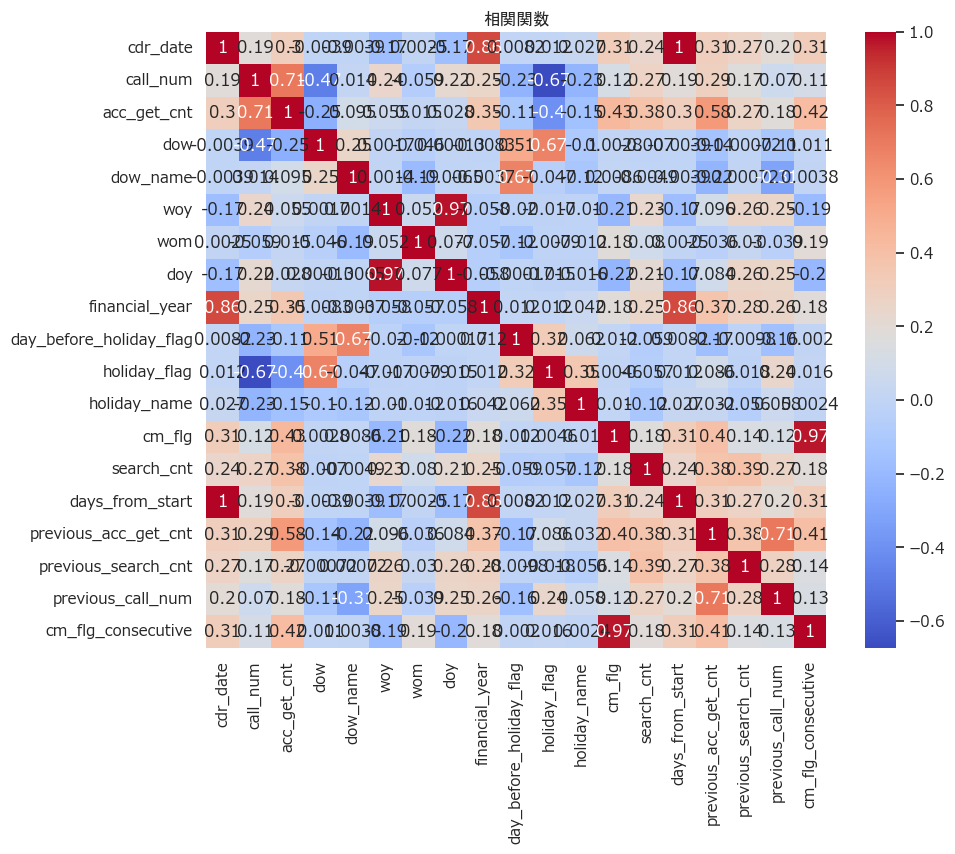

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns
correlation_matrix = filtered_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('相関関数', fontname="MS Gothic")
plt.show()

In [78]:
filtered_df.columns

Index(['cdr_date', 'call_num', 'acc_get_cnt', 'dow', 'dow_name', 'woy', 'wom',
       'doy', 'financial_year', 'day_before_holiday_flag', 'holiday_flag',
       'holiday_name', 'cm_flg', 'search_cnt', 'days_from_start',
       'previous_acc_get_cnt', 'previous_search_cnt', 'previous_call_num',
       'cm_flg_consecutive'],
      dtype='object')

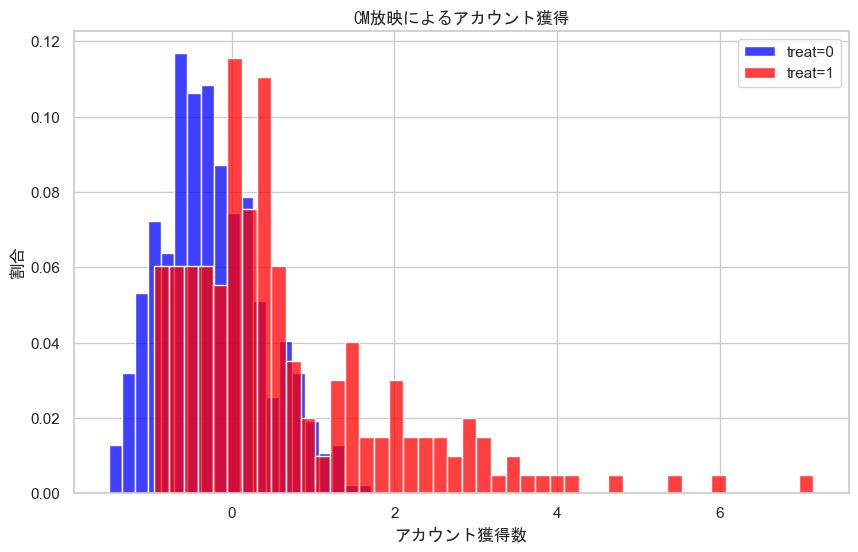

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

treat_0 = filtered_df[filtered_df['cm_flg'] == 0]
treat_1 = filtered_df[filtered_df['cm_flg'] == 1]
total_samples = len(filtered_df)

plt.figure(figsize=(10, 6))
sns.histplot(treat_0['acc_get_cnt'], color='blue', label='treat=0', stat='probability', bins=20)
sns.histplot(treat_1['acc_get_cnt'], color='red', label='treat=1', stat='probability', bins=45)

plt.title('CM放映によるアカウント獲得', fontname="MS Gothic")
plt.xlabel('アカウント獲得数', fontname="MS Gothic")
plt.ylabel('割合', fontname="MS Gothic")
plt.legend()
plt.show()

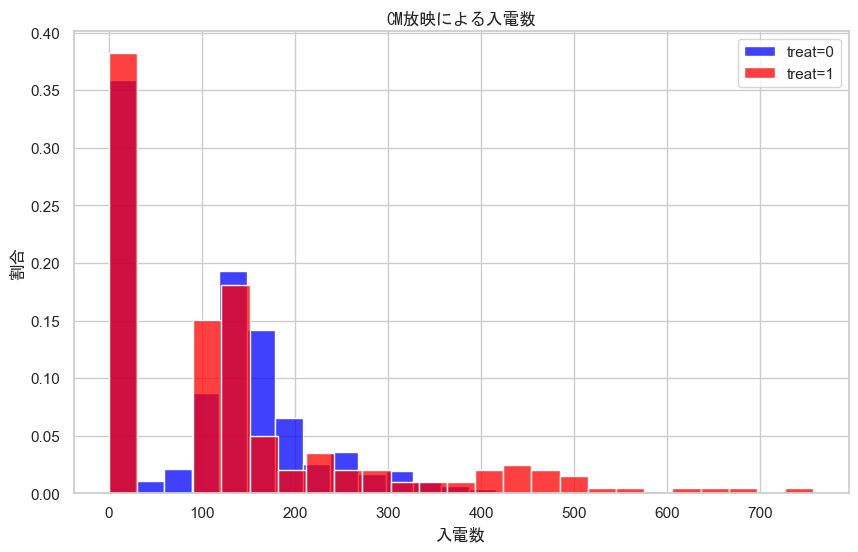

In [80]:
treat_0 = filtered_df[filtered_df['cm_flg'] == 0]
treat_1 = filtered_df[filtered_df['cm_flg'] == 1]
total_samples = len(filtered_df)

plt.figure(figsize=(10, 6))
sns.histplot(treat_0['call_num'], color='blue', label='treat=0', stat='probability', bins=20)
sns.histplot(treat_1['call_num'], color='red', label='treat=1', stat='probability', bins=25)

plt.title('CM放映による入電数', fontname="MS Gothic")
plt.xlabel('入電数', fontname="MS Gothic")
plt.ylabel('割合', fontname="MS Gothic")

plt.legend()
plt.show()

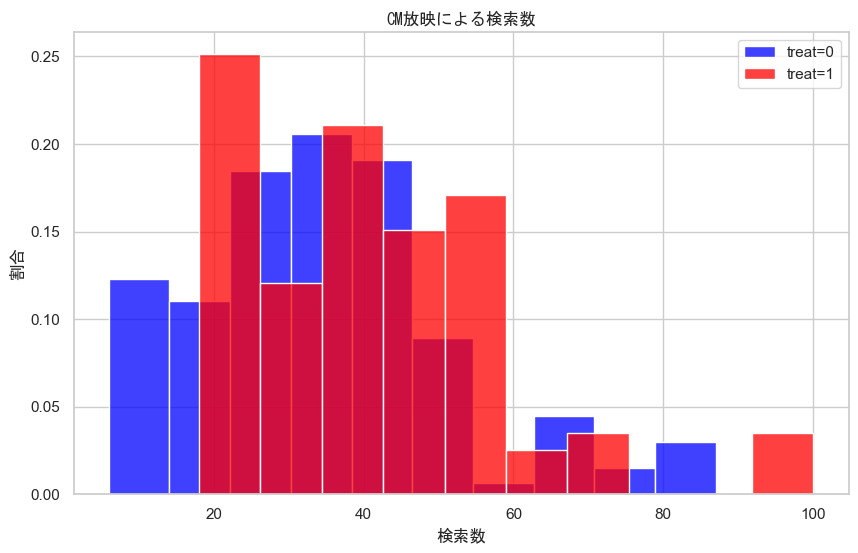

In [81]:
sns.set(style="whitegrid")

treat_0 = filtered_df[filtered_df['cm_flg'] == 0]
treat_1 = filtered_df[filtered_df['cm_flg'] == 1]
total_samples = len(filtered_df)

plt.figure(figsize=(10, 6))
sns.histplot(treat_0['search_cnt'], color='blue', label='treat=0', stat='probability', bins=10)
sns.histplot(treat_1['search_cnt'], color='red', label='treat=1', stat='probability', bins=10)

plt.title('CM放映による検索数', fontname="MS Gothic")
plt.xlabel('検索数', fontname="MS Gothic")
plt.ylabel('割合', fontname="MS Gothic")

plt.legend()
plt.show()

In [82]:
average_search_cnt = filtered_df.groupby('cm_flg')['search_cnt'].mean()
average_call_num = filtered_df.groupby('cm_flg')['call_num'].mean()
average_acc_get_cnt = filtered_df.groupby('cm_flg')['acc_get_cnt'].mean()
print(average_search_cnt)
print(average_call_num)
print(average_acc_get_cnt)

cm_flg
0    34.611465
1    41.456853
Name: search_cnt, dtype: float64
cm_flg
0    107.278132
1    138.276382
Name: call_num, dtype: float64
cm_flg
0   -0.247681
1    0.702629
Name: acc_get_cnt, dtype: float64


In [83]:
X = sm.add_constant(filtered_df[['dow', 'dow_name', 'woy', 'wom',
       'doy', 'financial_year', 'day_before_holiday_flag', 'holiday_flag',
       'holiday_name', 'days_from_start',
       'previous_acc_get_cnt','acc_get_cnt',
       'previous_search_cnt','search_cnt','call_num','previous_call_num']])
y = filtered_df['cm_flg']

model = sm.OLS(y, X)
result = model.fit()
result.summary()
#これは変えないといけない

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 cm_flg   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     26.23
Date:                Tue, 30 Jul 2024   Prob (F-statistic):           5.22e-60
Time:                        00:04:54   Log-Likelihood:                -259.68
No. Observations:                 670   AIC:                             553.4
Df Residuals:                     653   BIC:                             630.0
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     746.2656    117.814      6.334      0.000     514.926     977.606
dow                        -0.0131      0.012     -1.055      0.292      -0.037       0.011
dow_name                   -0.0121      0.012     -0.976      0.330      -0.036       0.012
woy                         0.0024      0.004      0.567      0.571      -0.006       0.011
wom                         0.0546      0.011      4.860      0.000       0.033       0.077
doy                        -0.0009      0.001     -1.556      0.120      -0.002       0.000
financial_year             -0.3697      0.058     -6.332      0.000      -0.484      -0.255
day_before_holiday_flag     0.0441      0.050      0.890      0.374      -0.053       0.141
holiday_flag                0.0880      0.060      1.459      0.145      -0.030       0.206
holiday_name                0.0325      0.076      0.429      0.668      -0.116       0.181
days_from_start             0.0011      0.000      7.442      0.000       0.001       0.001
previous_acc_get_cnt        0.1570      0.037      4.236      0.000       0.084       0.230
acc_get_cnt                 0.1466      0.037      3.969      0.000       0.074       0.219
previous_search_cnt        -0.0005      0.002     -0.275      0.783      -0.004       0.003
search_cnt                  0.0002      0.002      0.138      0.890      -0.003       0.003
call_num                   -0.0004      0.000     -1.532      0.126      -0.001       0.000
previous_call_num          -0.0005      0.000     -2.178      0.030      -0.001    -4.7e-05
==============================================================================
Omnibus:                       44.937   Durbin-Watson:                   0.189
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.528
Skew:                           0.678   Prob(JB):                     3.92e-12
Kurtosis:                       2.792   Cond. No.                     1.74e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.74e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [116]:
import dowhy
from dowhy import CausalModel

# Create a causal model
model = CausalModel(
    data=filtered_df,
    treatment='cm_flg',
    outcome='acc_get_cnt',
    common_causes=['days_from_start','search_cnt']
)

# Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

# Estimate the causal effect
estimate = model.estimate_effect(identified_estimand, method_name='backdoor.propensity_score_matching')

# Refute the estimated effect
refute_results = model.refute_estimate(identified_estimand, estimate, method_name='random_common_cause')

# Print the results
print(estimate)
print(refute_results)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                               
─────────(E[acc_get_cnt|days_from_start,search_cnt])
d[cm_flg]                                           
Estimand assumption 1, Unconfoundedness: If U→{cm_flg} and U→acc_get_cnt then P(acc_get_cnt|cm_flg,days_from_start,search_cnt,U) = P(acc_get_cnt|cm_flg,days_from_start,search_cnt)

## Realized estimand
b: acc_get_cnt~cm_flg+days_from_start+search_cnt
Target units: ate

## Estimate
Mean value: 0.3214416993344156

Refute: Add a random common cause
Estimated effect:0.3214416993344156
New effect:0.32144169933441546
p value:1.0



In [100]:
model = CausalModel(
    data=filtered_df,
    treatment='cm_flg',
    outcome='call_num',
    common_causes=['dow', 'dow_name', 'woy', 'wom',
       'doy', 'financial_year', 'day_before_holiday_flag', 'holiday_flag',
       'holiday_name', 'days_from_start',
       'previous_acc_get_cnt', 'cm_flg_consecutive',
       'previous_search_cnt']
)

# Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

# Estimate the causal effect
estimate = model.estimate_effect(identified_estimand, method_name='backdoor.propensity_score_matching')

# Refute the estimated effect
refute_results = model.refute_estimate(identified_estimand, estimate, method_name='random_common_cause')

# Print the results
print(estimate)
print(refute_results)

C:\Users\81803\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\81803\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\dowhy\causal_estimators\propensity_score_estimator.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                                                          ↪
─────────(E[call_num|holiday_name,financial_year,day_before_holiday_flag,cm_fl ↪
d[cm_flg]                                                                      ↪

↪                                                                              ↪
↪ g_consecutive,dow,wom,days_from_start,dow_name,doy,holiday_flag,previous_acc ↪
↪                                                                              ↪

↪                                   
↪ _get_cnt,woy,previous_search_cnt])
↪                                   
Estimand assumption 1, Unconfoundedness: If U→{cm_flg} and U→call_num then P(call_num|cm_flg,holiday_name,financial_year,day_before_holiday_flag,cm_flg_consecutive,dow,wom,days_from_start,dow_name,doy,holiday_flag,previous_acc_get_cnt,woy,previ

In [86]:
import dowhy
from dowhy import CausalModel

model = CausalModel(
    data=filtered_df,
    treatment='cm_flg',
    outcome='search_cnt',
    common_causes=['dow', 'dow_name', 'woy', 'wom',
       'doy', 'financial_year', 'day_before_holiday_flag', 'holiday_flag',
       'holiday_name', 'days_from_start',
       'previous_acc_get_cnt', 'cm_flg_consecutive',
       'previous_search_cnt']
)

# 因果効果の識別
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

# 因果効果の推定
estimate = model.estimate_effect(identified_estimand, method_name='backdoor.propensity_score_matching')

# 推定効果の検証
refute_results = model.refute_estimate(identified_estimand, estimate, method_name='random_common_cause')

# 結果の表示
print(estimate)
print(refute_results)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                                                          ↪
─────────(E[search_cnt|holiday_name,financial_year,day_before_holiday_flag,cm_ ↪
d[cm_flg]                                                                      ↪

↪                                                                              ↪
↪ flg_consecutive,dow,wom,days_from_start,dow_name,doy,holiday_flag,previous_a ↪
↪                                                                              ↪

↪                                     
↪ cc_get_cnt,woy,previous_search_cnt])
↪                                     
Estimand assumption 1, Unconfoundedness: If U→{cm_flg} and U→search_cnt then P(search_cnt|cm_flg,holiday_name,financial_year,day_before_holiday_flag,cm_flg_consecutive,dow,wom,days_from_start,dow_name,doy,holiday_flag,previous_acc_get_cnt

In [87]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 670 entries, 92 to 761
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   cdr_date                 670 non-null    datetime64[ns]
 1   call_num                 670 non-null    float64       
 2   acc_get_cnt              670 non-null    float64       
 3   dow                      670 non-null    float64       
 4   dow_name                 670 non-null    int64         
 5   woy                      670 non-null    float64       
 6   wom                      670 non-null    float64       
 7   doy                      670 non-null    float64       
 8   financial_year           670 non-null    float64       
 9   day_before_holiday_flag  670 non-null    int32         
 10  holiday_flag             670 non-null    int32         
 11  holiday_name             670 non-null    int64         
 12  cm_flg                   670 non-null   

C:\Users\81803\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22679 (\N{CJK UNIFIED IDEOGRAPH-5897}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\81803\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21152 (\N{CJK UNIFIED IDEOGRAPH-52A0}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\81803\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\81803\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\loc

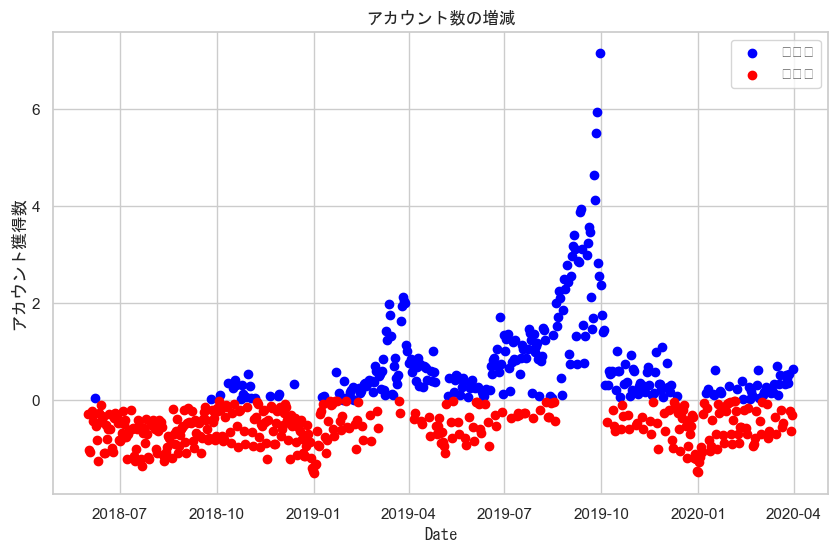

In [88]:
# プラスの日とマイナスの日に分ける
positive_days = filtered_df[filtered_df['acc_get_cnt'] >= 0]
negative_days = filtered_df[filtered_df['acc_get_cnt'] < 0]

# 可視化
plt.figure(figsize=(10, 6))
plt.scatter(positive_days['cdr_date'], positive_days['acc_get_cnt'], color='blue', label='増加日')
plt.scatter(negative_days['cdr_date'], negative_days['acc_get_cnt'], color='red', label='減少日')

plt.xlabel('Date',fontname="MS Gothic")
plt.ylabel('アカウント獲得数',fontname="MS Gothic")
plt.title('アカウント数の増減',fontname="MS Gothic")
plt.legend()
plt.show()

In [109]:
filtered_df

,cdr_date,call_num,acc_get_cnt,dow,dow_name,woy,wom,doy,financial_year,day_before_holiday_flag,holiday_flag,holiday_name,cm_flg,search_cnt,days_from_start,previous_acc_get_cnt,previous_search_cnt,previous_call_num,cm_flg_consecutive,propensity_score
92,2018-06-01,183.0,-0.282652,5.0,6,22.0,1.0,152.0,2018.0,1,0,0,0,6.000000,0,0.000000,0.000000,0.0,0,0.021899
93,2018-06-02,0.0,-1.025720,6.0,7,22.0,1.0,153.0,2018.0,1,1,0,0,6.000000,1,-0.282652,6.000000,183.0,0,0.007079
94,2018-06-03,0.0,-1.075258,7.0,1,22.0,2.0,154.0,2018.0,0,1,0,0,18.000000,2,-1.025720,6.000000,0.0,0,0.018359
95,2018-06-04,213.0,-0.220730,1.0,2,23.0,2.0,155.0,2018.0,0,0,0,0,18.000000,3,-1.075258,18.000000,0.0,0,0.004532
96,2018-06-05,143.0,-0.431266,2.0,3,23.0,2.0,156.0,2018.0,0,0,0,0,18.000000,4,-0.220730,18.000000,213.0,0,0.033112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
757,2020-03-27,127.0,0.534723,5.0,6,13.0,4.0,87.0,2019.0,1,0,0,1,25.000000,665,0.348956,25.000000,114.0,1,0.948235
758,2020-03-28,0.0,-0.220730,6.0,7,13.0,4.0,88.0,2019.0,1,1,0,1,25.000000,666,0.534723,25.000000,127.0,1,0.961911
759,2020-03-29,0.0,-0.641802,7.0,1,13.0,5.0,89.0,2019.0,0,1,0,1,20.000000,667,-0.220730,25.000000,0.0,1,0.984595
760,2020-03-30,134.0,-0.307421,1.0,2,14.0,5.0,90.0,2019.0,0,0,0,1,41.456853,668,-0.641802,20.000000,0.0,1,0.877773


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 723
[LightGBM] [Info] Number of data points in the train set: 469, number of used features: 15
[LightGBM] [Info] Start training from score 117.865672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

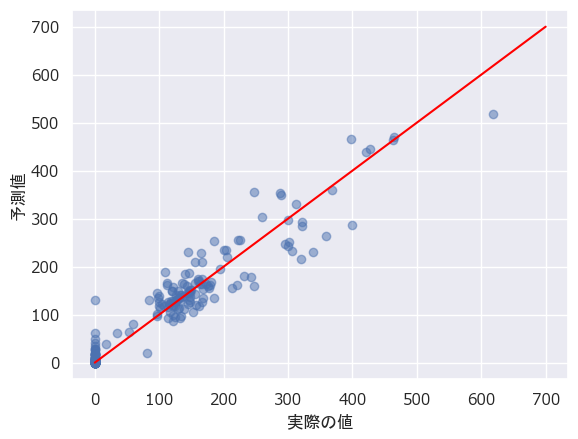

In [119]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns


train_df = filtered_df[['dow', 'dow_name', 'woy', 'wom',
       'doy', 'financial_year', 'day_before_holiday_flag', 'holiday_flag',
       'holiday_name', 'cm_flg', 'days_from_start',
       'previous_acc_get_cnt', 'propensity_score', 'cm_flg_consecutive',
       'previous_search_cnt']]#call_num,previous_acc_get_cnt
target_df = filtered_df[['call_num']]

#モデル学習のための、訓練データとテストデータを7:3で分割
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_df, target_df, test_size=0.3)



dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_test, y_test)


#モデルパラメータの設定
params = {'metric' : 'rmse'}
model = lgb.train(params,dtrain)

#予測の実行と書き出し
pred = model.predict(X_test)
pred[pred < 0] = 0
print(pred)

#散布図で予測の精度を描写
sns.set(font=['Meiryo','Yu Gothic'])
plt.scatter(y_test, pred, alpha = 0.5)
plt.plot(np.linspace(0, 700, 700), np.linspace(0, 700, 700), "red")
plt.xlabel('実際の値' ,fontname="MS Gothic")
plt.ylabel('予測値',  fontname="MS Gothic")
plt.show()

In [118]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = mean_squared_error(y_test, pred, squared=False)
print("RMSE:", rmse)

# MAEを計算
mae = mean_absolute_error(y_test, pred)
print("MAE:", mae)

RMSE: 37.28519475623791
MAE: 24.0118982136745


'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.


In [111]:
filtered_df

,cdr_date,call_num,acc_get_cnt,dow,dow_name,woy,wom,doy,financial_year,day_before_holiday_flag,holiday_flag,holiday_name,cm_flg,search_cnt,days_from_start,previous_acc_get_cnt,previous_search_cnt,previous_call_num,cm_flg_consecutive,propensity_score
92,2018-06-01,183.0,-0.282652,5.0,6,22.0,1.0,152.0,2018.0,1,0,0,0,6.000000,0,0.000000,0.000000,0.0,0,0.021899
93,2018-06-02,0.0,-1.025720,6.0,7,22.0,1.0,153.0,2018.0,1,1,0,0,6.000000,1,-0.282652,6.000000,183.0,0,0.007079
94,2018-06-03,0.0,-1.075258,7.0,1,22.0,2.0,154.0,2018.0,0,1,0,0,18.000000,2,-1.025720,6.000000,0.0,0,0.018359
95,2018-06-04,213.0,-0.220730,1.0,2,23.0,2.0,155.0,2018.0,0,0,0,0,18.000000,3,-1.075258,18.000000,0.0,0,0.004532
96,2018-06-05,143.0,-0.431266,2.0,3,23.0,2.0,156.0,2018.0,0,0,0,0,18.000000,4,-0.220730,18.000000,213.0,0,0.033112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
757,2020-03-27,127.0,0.534723,5.0,6,13.0,4.0,87.0,2019.0,1,0,0,1,25.000000,665,0.348956,25.000000,114.0,1,0.948235
758,2020-03-28,0.0,-0.220730,6.0,7,13.0,4.0,88.0,2019.0,1,1,0,1,25.000000,666,0.534723,25.000000,127.0,1,0.961911
759,2020-03-29,0.0,-0.641802,7.0,1,13.0,5.0,89.0,2019.0,0,1,0,1,20.000000,667,-0.220730,25.000000,0.0,1,0.984595
760,2020-03-30,134.0,-0.307421,1.0,2,14.0,5.0,90.0,2019.0,0,0,0,1,41.456853,668,-0.641802,20.000000,0.0,1,0.877773
